## ICU Outcome Prediction
Clinical Trajectory Modeling

#### Importing Packages & Configuring

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score,
    confusion_matrix, precision_recall_curve,
    roc_curve, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import shap
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set(rc={'figure.figsize': (12,8)})

In [2]:
import warnings
warnings.filterwarnings("ignore")

#### Loading Cleaned Features (From Notebook 2)

In [3]:
df = pd.read_csv("Data/Generated/clean_patient_level_features.csv")
df.head()

,AGE,LOS_hours,ICU_LOS_hours,charlson,lactate,platelets,creatinine,bun,sodium,potassium,bilirubin,hemoglobin,SUBJECT_ID,HOSPITAL_EXPIRE_FLAG
0,0,92.733333,2.203889,1,2.000000,153.5,1.00,20.00,139.0,4.166667,0.70,10.883333,2,0
1,76,258.833333,145.549444,0,4.871429,271.0,2.65,44.75,139.2,4.360000,0.80,9.850000,3,0
2,48,186.216667,40.283333,1,2.100000,204.0,0.50,9.50,138.0,3.200000,2.05,10.500000,4,0
3,0,55.733333,2.026667,1,2.000000,309.0,1.00,20.00,139.0,4.166667,0.70,10.883333,5,0
4,66,392.750000,88.150000,0,2.640000,322.5,10.85,63.50,136.0,5.100000,0.20,9.080000,6,0


#### Define ML Targets

**Primary target**: HOSPITAL_EXPIRE_FLAG ← 0/1 mortality prediction <br>
**Secondary target**: LOS_hours ← regression (optional), or classify LOS > 48 hrs

In [5]:
target_mortality = "HOSPITAL_EXPIRE_FLAG"
target_los = "LOS_hours"

y = df[target_mortality]
X = df.drop([target_mortality, target_los, "SUBJECT_ID", "ICU_LOS_hours"], axis=1)

#### Train/Val/Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### Scale Continuous Variables

In [7]:
num_cols = X.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

### MODELS TO TRAIN
1. Logistic Regression (clinical baseline)
2. Random Forest (nonlinear interactions)
3. XGBoost (SOTA clinical ML)

#### Logistic Regression

In [8]:
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train, y_train)

log_pred = logreg.predict(X_test)
log_prob = logreg.predict_proba(X_test)[:,1]

print("LogReg AUC =", roc_auc_score(y_test, log_prob))
print(classification_report(y_test, log_pred))

LogReg AUC = 0.7825103876382933
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2446
           1       0.59      0.07      0.13       294

    accuracy                           0.90      2740
   macro avg       0.75      0.53      0.54      2740
weighted avg       0.87      0.90      0.86      2740



#### Random Forest Classifier

In [9]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_split=5,
    random_state=42
)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:,1]

print("RF AUC =", roc_auc_score(y_test, rf_prob))
print(classification_report(y_test, rf_pred))

RF AUC = 0.85266796825026
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2446
           1       0.71      0.13      0.22       294

    accuracy                           0.90      2740
   macro avg       0.81      0.56      0.59      2740
weighted avg       0.88      0.90      0.87      2740



#### XGBoost Classifier (Best Performing for Clinical Data)

In [10]:
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)[:,1]

In [11]:
print("XGBoost AUC =", roc_auc_score(y_test, xgb_prob))
print(classification_report(y_test, xgb_pred))

XGBoost AUC = 0.8414918706648645
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2446
           1       0.64      0.19      0.29       294

    accuracy                           0.90      2740
   macro avg       0.78      0.59      0.62      2740
weighted avg       0.88      0.90      0.88      2740



#### Compare Models (ROC Curves)

In [12]:
models = {
    "Logistic Regression": log_prob,
    "Random Forest": rf_prob,
    "XGBoost": xgb_prob
}

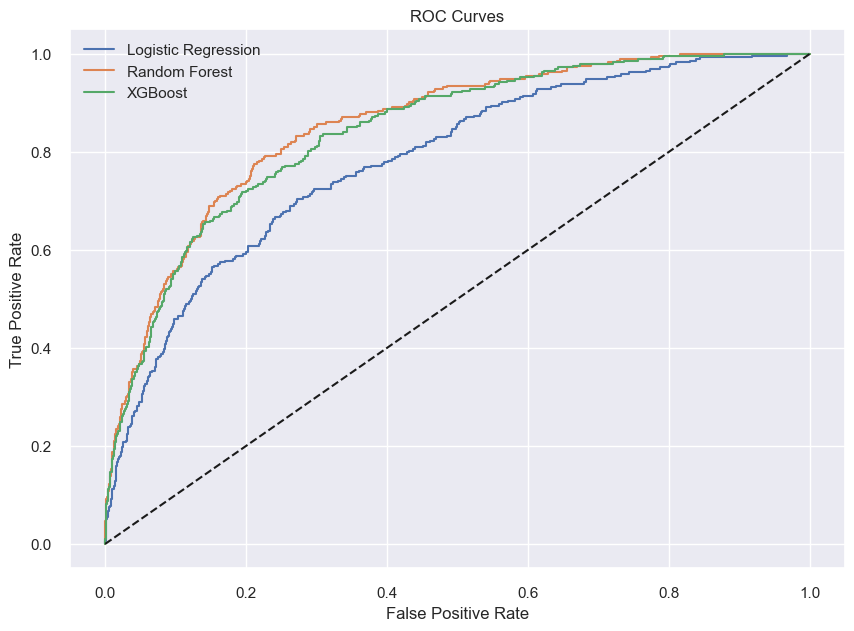

In [13]:
plt.figure(figsize=(10,7))

for name, prob in models.items():
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

#### Precision–Recall Curves (Better for Imbalanced Data)

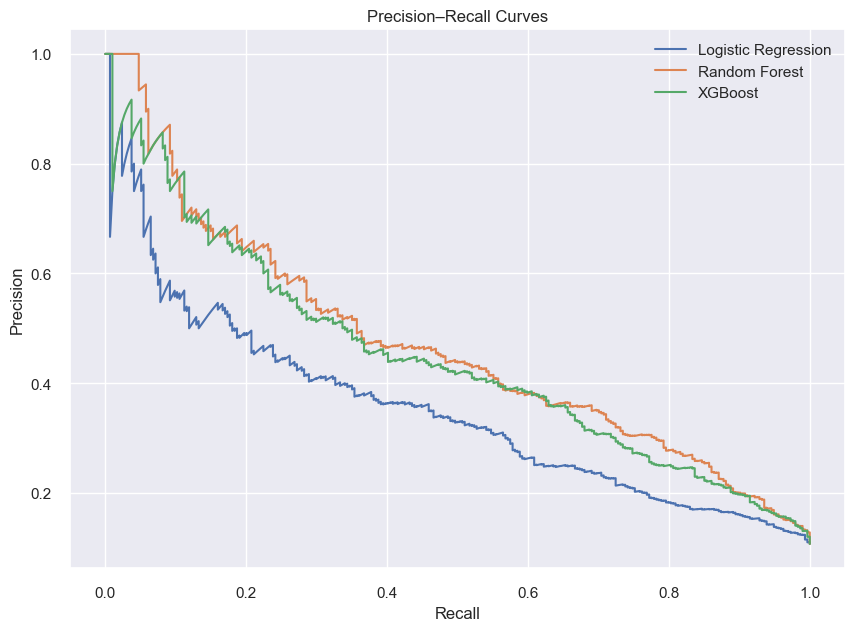

In [14]:
plt.figure(figsize=(10,7))

for name, prob in models.items():
    precision, recall, _ = precision_recall_curve(y_test, prob)
    plt.plot(recall, precision, label=name)

plt.title("Precision–Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

#### Feature Importance (Clinical Interpretability)

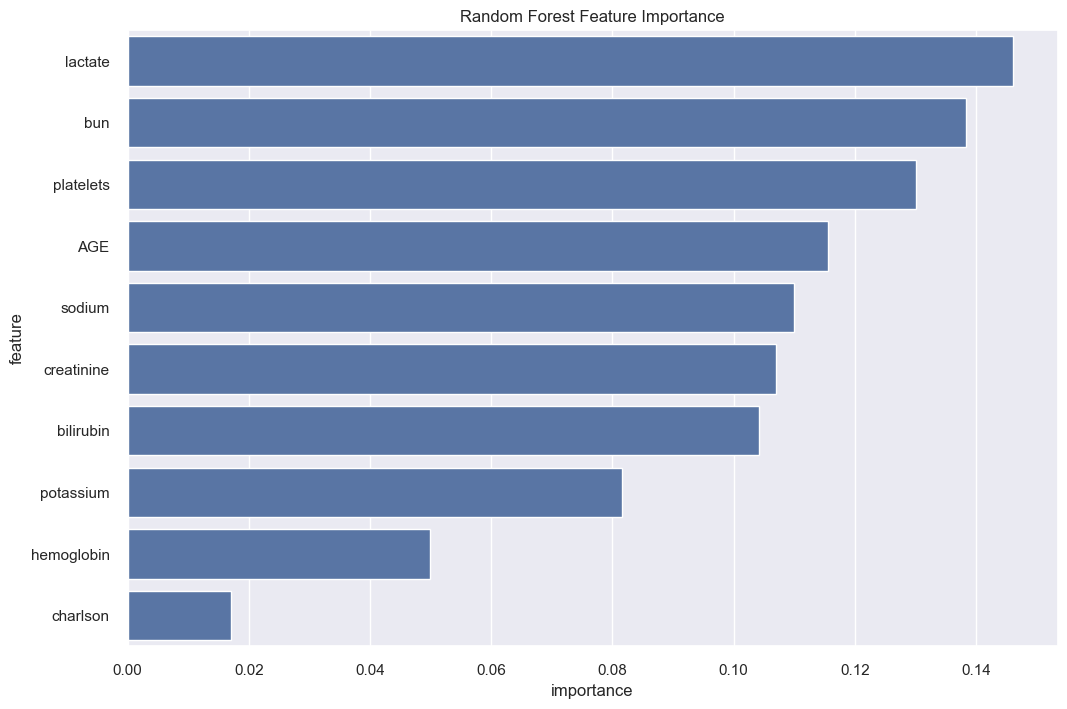

In [15]:
rf_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False).head(20)

sns.barplot(data=rf_importance, x='importance', y='feature')
plt.title("Random Forest Feature Importance")
plt.show()

#### SHAP Interpretation for XGBoost

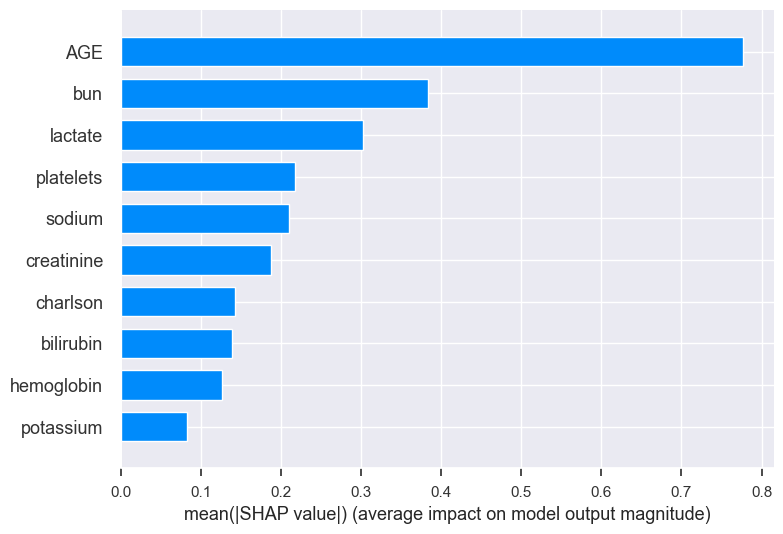

In [16]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

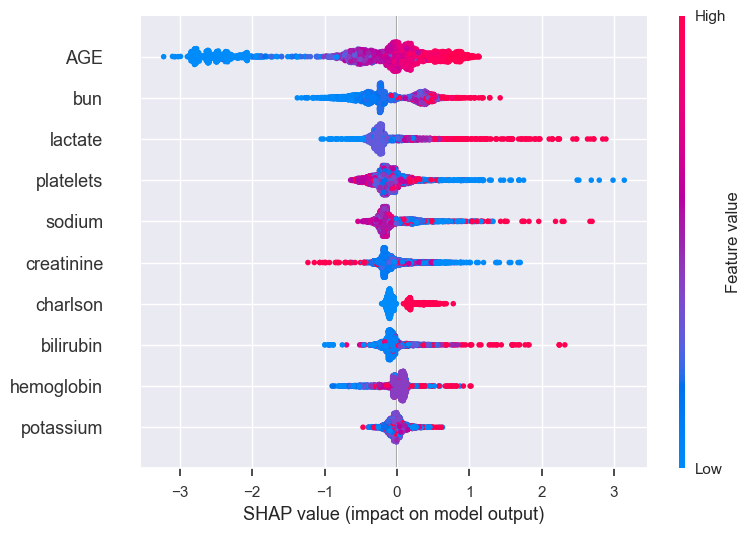

In [17]:
shap.summary_plot(shap_values, X_test)

#### Calibration Curve
Clinicians trust calibrated models.

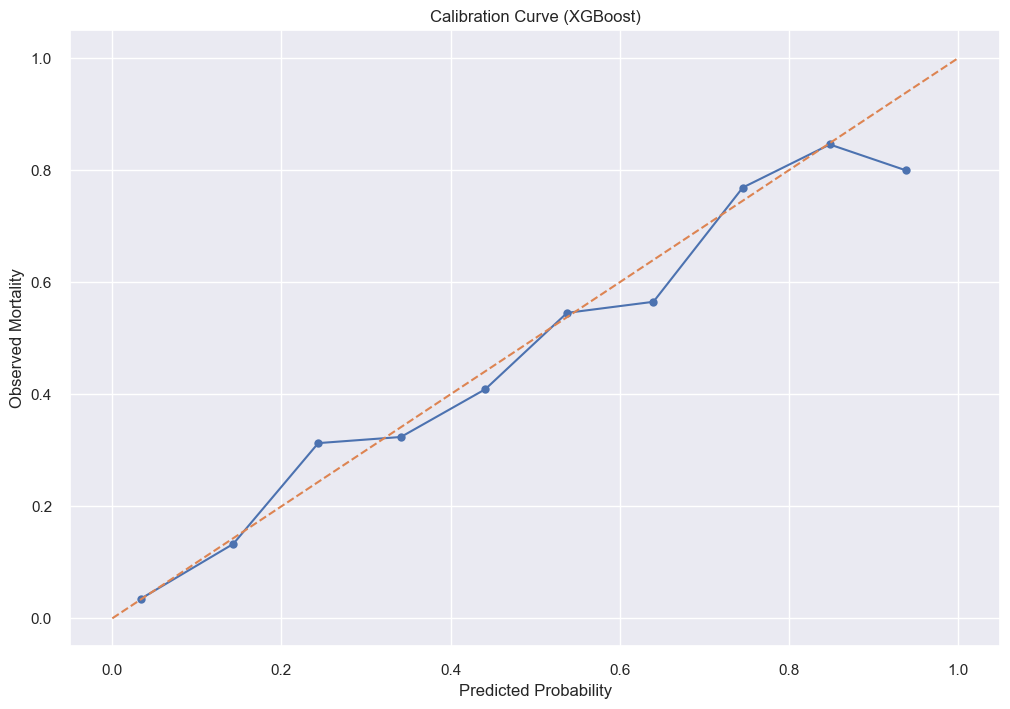

In [18]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, xgb_prob, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], '--')
plt.title("Calibration Curve (XGBoost)")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Mortality")
plt.show()

#### Bias / Fairness Check
Check for age-related prediction bias.

In [19]:
df_test = X_test.copy()
df_test['y_true'] = y_test
df_test['y_pred'] = xgb_pred
df_test['age'] = X.loc[X_test.index, 'AGE']

df_test['age_group'] = pd.cut(df_test['age'], bins=[18,40,60,90], labels=['18-40','41-60','61-90'])

df_test.groupby('age_group', observed=False)[['y_pred','y_true']].mean()

,y_pred,y_true
age_group,,
18-40,0.004464,0.066964
41-60,0.041298,0.106195
61-90,0.040201,0.145729


#### Save Model + Scaler for Deployment

In [20]:
import pickle

pickle.dump(xgb, open("Models/xgb_mortality_model.pkl", "wb"))
pickle.dump(scaler, open("Models/scaler.pkl", "wb"))

#### Export Predictions for Dashboard (Power BI / Web App)

In [21]:
output = pd.DataFrame({
    'patient_id': df.loc[X_test.index, 'SUBJECT_ID'],
    'mortality_prob': xgb_prob,
    'mortality_pred': xgb_pred,
})

output.to_csv("Data/Generated/mortality_predictions_for_dashboard.csv", index=False)